# Run FUDGE generation

In [52]:
# Imports

import os
import torch

from hyformer.configs.dataset import DatasetConfig
from hyformer.configs.tokenizer import TokenizerConfig
from hyformer.configs.model import ModelConfig
from hyformer.configs.trainer import TrainerConfig

from hyformer.utils.datasets.auto import AutoDataset
from hyformer.utils.tokenizers.auto import AutoTokenizer
from hyformer.models.auto import AutoModel
from hyformer.trainers.trainer import Trainer

from hyformer.utils.runtime import set_seed



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Set logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [54]:
!pwd

/ictstr01/home/aih/adam.izdebski/project/hyformer-interface/hyformer


In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [56]:
# Configs

DATA_DIR = '/lustre/groups/aih/hyformer/icml25/data'
OUTPUT_DIR = '/home/adamizdebski/projects/hyformer/results/finetune'

PATH_TO_DATASET_CONFIG   = 'configs/datasets/guacamol_binary_qed/config.json'
PATH_TO_TOKENIZER_CONFIG = 'configs/tokenizers/smiles_separate_task_token_future/config.json'
PATH_TO_MODEL_CONFIG = 'configs/models/hyformer_prediction_best_big/config.json'
PATH_TO_TRAINER_CONFIG = 'configs/trainers/fudge/config.json'

In [58]:
# Define QED oracle (unnormalized)

from hyformer.utils.properties.smiles.qed import QED
from hyformer.utils.properties.smiles.physchem import PhysChem
from hyformer.utils.chemistry import is_valid


class QEDOracle:

    def __init__(self, verbose=False, dtype='torch'):
        self.oracle = PhysChem(verbose=verbose, dtype=dtype)

    def __call__(self, smiles):
        return self.oracle(smiles)[-1]
    
oracle = QEDOracle(verbose=False, dtype='np')

In [59]:
# set seed 

set_seed(1337)

INFO: Random seed set to 1337


In [8]:
# import pandas as pd


# df = pd.DataFrame({
#     'QED': sum([results[method]['qed'] for method in results.keys()], []),
#     'method': sum([method for i in range(len(results[method]['qed'])) for method in results.keys()], [])
# })

# df

In [9]:
# sns.kdeplot(df, fill=True, alpha=0.5, x='QED', hue='')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot(results):

    # Set the colors
    sns.set_theme(style="whitegrid", font_scale=1.5)
    colors = sns.color_palette("colorblind", len(results))

    # Create the density plot
    plt.figure(figsize=(10, 6))
    idx = 0
    for key, _ in results.items():    
        color = results[key]['color'] if 'color' in results[key] else colors[idx]
        sns.kdeplot(np.array([float(number) for number in results[key]['qed']]), fill=True, alpha=0.3, linewidth=2, label=key, color=colors[idx])
        idx += 1

    # add veritcal line
    plt.axvline(0.9, 0, 1.17, color='black', linestyle='--')
    plt.xlim(0, 1)
    plt.ylim(0, None)
    
    # Add labels and title
    plt.xlabel("QED")
    plt.ylabel("Density")
    plt.title("Drug-likeliness (QED) distribution")
    plt.legend()

    # Show the plot__
    plt.show()

plot(results)
        

NameError: name 'results' is not defined

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot(results):
    """
    Generates an ICML-ready density plot for QED distribution with black lines and clear axes.

    Parameters:
    - results: Dictionary where keys are labels and values contain 'qed' (list of values) and optional 'color'.
    """
    # Set the ICML-style Seaborn theme with a white grid background
    sns.set_theme(style="whitegrid", font_scale=1.5)
    
    # Create the plot
    plt.figure(figsize=(10, 6))  # Larger size for better clarity

    # Ensure all KDE lines are black for consistency
    for key in results.keys():
        sns.kdeplot(
            np.array([float(number) for number in results[key]['qed']]), 
            fill=True, alpha=0.3, label=key, color="black", linewidth=2
        )

    # Set x-axis range [0, 1] and y-axis from 0
    plt.xlim(0, 1)
    plt.ylim(0, None)  # Ensures density is well represented

    # Add a bold vertical reference line at QED = 0.9
    plt.axvline(0.9, color="black", linestyle="dashed", linewidth=3, label="QED Threshold")

    # Annotate the threshold for clarity
    plt.text(0.91, plt.ylim()[1] * 0.85, "QED = 0.9", fontsize=14, color="black", fontweight="bold")

    # Improve axis visibility with thicker ticks and lines
    plt.xlabel("QED", fontsize=18, fontweight="bold", color="black")
    plt.ylabel("Density", fontsize=18, fontweight="bold", color="black")
    plt.title("Drug-likeliness (QED) Distribution", fontsize=20, fontweight="bold", color="black")

    # Customize axis ticks for better readability
    plt.xticks(fontsize=14, fontweight="bold", color="black")
    plt.yticks(fontsize=14, fontweight="bold", color="black")

    # Improve legend visibility with a white background and bold font
    plt.legend(fontsize=14, loc="upper left", frameon=True, edgecolor="black", facecolor="white")

    # Thicken axes for high-contrast visibility
    plt.gca().spines["bottom"].set_linewidth(2)
    plt.gca().spines["left"].set_linewidth(2)
    plt.gca().spines["top"].set_linewidth(0)  # Hide top spine for cleaner look
    plt.gca().spines["right"].set_linewidth(0)  # Hide right spine for cleaner look

    # Show the plot
    plt.show()


In [13]:
np.array([float(number) for number in results['best-of-k']['qed']])

NameError: name 'results' is not defined

In [14]:
results = {}

In [15]:
rgb_distance = lambda x: np.sqrt(np.sum((x - 0.9) ** 2)) / 0.15

In [16]:
# Implement metrics

import numpy as np
from hyformer.utils.chemistry import is_valid

def calculate_mean_absolute_deviation(properties:np.array, target: float):
    _properties = properties[~np.isnan(properties)]
    return np.mean(np.abs(_properties - target))

def calculate_standard_deviation(properties: np.array):
    _properties = properties[~np.isnan(properties)]
    return np.std(_properties)

def calculate_validity(smiles):
    _is_valid = [is_valid(smile) for smile in smiles]
    return sum(_is_valid) / len(_is_valid)

## Dataset Baseline

In [17]:
# Sample 5K examples from the train set of Guacamol

PATH_TO_DATASET_CONFIG   = 'configs/datasets/guacamol_binary_qed/config.json'

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')


In [18]:
smiles = [train_dataset[idx][0] for idx in range(len(train_dataset))]
properties =  oracle(smiles)

In [19]:
results['dataset'] = {}
results['dataset']['smiles'] = smiles
results['dataset']['qed'] = [str(property) for property in properties.flatten()]
results['dataset']['color'] = 'blue'
results['dataset']['validity'] = str(calculate_validity(smiles))
results['dataset']['mad'] = str(calculate_mean_absolute_deviation(properties, 0.9))
results['dataset']['std'] = str(calculate_standard_deviation(properties))

In [20]:
results

{'dataset': {'smiles': ['COc1ccc(Oc2ccc(C(F)(F)F)cc2C(=O)Nc2cc[nH]c(=O)c2)cc1F',
   'Nc1nc2ccc(C(=O)c3ccccc3)cn2c1C(=O)c1c(F)cccc1F',
   'COc1ccc(C2c3cc4c(cc3OC(NCCO)C2C)OCO4)cc1',
   'CCOP(=S)(OCCC(C)CCC=C(C)C)OCCC(C)CCC=C(C)C',
   'Cc1cc([N+](=O)[O-])ccc1NC(=O)N1Cc2ccccc2C1',
   'COc1cccc(NC(=O)CSc2nc3cc(Br)c[nH]c-3n2)c1',
   'Cn1cnc([N+](=O)[O-])c1Oc1cccc(O)c1',
   'O=c1c(O)c(-c2ccc(O)c(O)c2)oc2c1ccc1ccccc12',
   'Cc1ccc(C2=NN(CCC(=O)NC3CCCC3)C(=O)CC2)cc1',
   'C=CCc1c(O)cc(O)c2c1OC(c1ccc(OC)cc1)CC2=O',
   'CC(C)=CCCC(C)CCOP(=O)(O)OP(=O)(O)OC1OC(CO)C(O)C(O)C1O',
   'O=c1[nH]c(CNc2ccccc2O)nc2c1sc1ccc(Cl)cc12',
   'COc1ccc(CC(=O)O)cc1-c1cc2c(n1C(C)C)C(c1ccc(Cl)cc1)N(c1cc(Cl)ccc1C)C2=O',
   'Cn1cc(CNCCc2nccs2)c(-c2cccnc2)n1',
   'COc1cc(CNC2Cc3ccccc3C2)ccc1Oc1ccc2nc[nH]c2c1',
   'C=CCONC(=O)c1nn(-c2ccc(OC)cc2)c2c1CCc1n[nH]cc1-2',
   'CC1CCN(c2ccc(NC(=O)c3cccnc3)cc2)CC1',
   'COc1ncc(C(=O)Nc2cccc(C(C)Nc3ncnc4c(C(N)=O)cccc34)c2)cc1Cl',
   'Oc1c(Cl)c(Cl)c(O)c(CCNc2nccs2)c1Cl',
   'O=C(O)c

In [21]:
# save dict to file

import os
import json

if not os.path.exists('results/conditional_generation/guacamol/qed/09'):
    os.makedirs('results/conditional_generation/guacamol/qed/09', exist_ok=False)

with open('results/conditional_generation/guacamol/qed/09/results.json', 'w') as f:
    json.dump(results, f, indent=4)

## Unconditional Generation

In [60]:
PATH_TO_DATASET_CONFIG   = 'configs/datasets/guacamol_binary_qed/config.json'
PATH_TO_TOKENIZER_CONFIG = 'configs/tokenizers/smiles_separate_task_token/config.json'
PATH_TO_MODEL_CONFIG = 'configs/models/hyformer_prediction_deep/config.json'
PATH_TO_TRAINER_CONFIG = 'configs/trainers/fudge/config.json'

PATH_TO_MODEL_CKPT = '/lustre/groups/aih/hyformer/icml25/results/pretrain/guacamol/hyformer/llama_backbone/pretrain_generation_mlm_physchem/ckpt.pt'

In [64]:
tokenizer_config = TokenizerConfig.from_config_file(PATH_TO_TOKENIZER_CONFIG)
tokenizer = AutoTokenizer.from_config(tokenizer_config)

# Model

model_config = ModelConfig.from_config_file(PATH_TO_MODEL_CONFIG)
model = AutoModel.from_config(model_config, downstream_task="regression", num_tasks=1)
model.load_pretrained(PATH_TO_MODEL_CKPT)
model.to(device)
model.eval()


HyformerForDownstreamPredictionDeep(
  (token_embedding): Embedding(596, 256)
  (layers): ModuleList(
    (0-7): 8 x TransformerLayer(
      (attention_layer): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=False)
        (out): Linear(in_features=256, out_features=256, bias=False)
        (relative_embedding): RotaryPositionalEmbedding()
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w3): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_layer_normalization): RMSNorm()
      (feed_forward_normalization): RMSNorm()
    )
  )
  (layer_norm): RMSNorm()
  (lm_head): Linear(in_features=256, out_features=596, bias=False)
  (mlm_head): Linear(in_features=256, out_features=596, bias=False)
  (physchem_head): RegressionHead(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=256

In [65]:
# Generate 2.5K samples from the model

from tqdm.auto import tqdm

smiles = []

for _ in tqdm(range(10)):
    samples = model.generate(tokenizer=tokenizer, batch_size=256, temperature=1.0, top_k=25, device=device).detach().cpu()
    smiles.extend(tokenizer.decode(samples))    



 40%|████      | 4/10 [00:36<00:54,  9.09s/it]


KeyboardInterrupt: 

In [25]:
properties = oracle(smiles)

In [26]:
results['unconditional-generation'] = {}
results['unconditional-generation']['smiles'] = smiles
results['unconditional-generation']['qed'] = [str(property) for property in properties.flatten()]
results['unconditional-generation']['color'] = 'red'
results['unconditional-generation']['validity'] = str(calculate_validity(smiles))
results['unconditional-generation']['mad'] = str(calculate_mean_absolute_deviation(properties, 0.9))
results['unconditional-generation']['std'] = str(calculate_standard_deviation(properties))

In [27]:
with open('results/conditional_generation/guacamol/qed/09/results.json', 'w') as f:
    json.dump(results, f, indent=4)

## Best of K

In [62]:
@torch.no_grad()
def predict_qed(model, input_ids: torch.Tensor, attention_mask: torch.Tensor, **kwargs):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, task='prediction')
        _logits = outputs['logits_physchem']
        return _logits


In [63]:
# predict QED for the generated samples in chunks

logits = torch.zeros(len(smiles), )
for idx in range(0, len(smiles), 128):
    _data = smiles[idx:idx+128]
    inputs = tokenizer(_data, task='prediction').to(device)
    _logits = predict_qed(model, **inputs)[:, -1].cpu()
    logits[idx:idx+128] = _logits

logits = logits.numpy()

NameError: name 'smiles' is not defined

In [84]:
len(logits) == len(logits)

True

In [85]:
smiles_selected = [smiles[idx] for idx in range(len(smiles)) if logits[idx] > 0.9]
properties_selected = properties[logits > 0.9]

In [86]:
results['best-of-k'] = {}
results['best-of-k']['smiles'] = smiles_selected
results['best-of-k']['qed'] = [str(property_selected) for property_selected in properties_selected.flatten()]
results['best-of-k']['color'] = 'green'
results['best-of-k']['validity'] = str(calculate_validity(smiles_selected))
results['best-of-k']['mad'] = str(calculate_mean_absolute_deviation(properties_selected, 0.9))
results['best-of-k']['std'] = str(calculate_standard_deviation(properties_selected))

In [87]:
results

{'dataset': {'smiles': ['COc1ccc(Oc2ccc(C(F)(F)F)cc2C(=O)Nc2cc[nH]c(=O)c2)cc1F',
   'Nc1nc2ccc(C(=O)c3ccccc3)cn2c1C(=O)c1c(F)cccc1F',
   'COc1ccc(C2c3cc4c(cc3OC(NCCO)C2C)OCO4)cc1',
   'CCOP(=S)(OCCC(C)CCC=C(C)C)OCCC(C)CCC=C(C)C',
   'Cc1cc([N+](=O)[O-])ccc1NC(=O)N1Cc2ccccc2C1',
   'COc1cccc(NC(=O)CSc2nc3cc(Br)c[nH]c-3n2)c1',
   'Cn1cnc([N+](=O)[O-])c1Oc1cccc(O)c1',
   'O=c1c(O)c(-c2ccc(O)c(O)c2)oc2c1ccc1ccccc12',
   'Cc1ccc(C2=NN(CCC(=O)NC3CCCC3)C(=O)CC2)cc1',
   'C=CCc1c(O)cc(O)c2c1OC(c1ccc(OC)cc1)CC2=O',
   'CC(C)=CCCC(C)CCOP(=O)(O)OP(=O)(O)OC1OC(CO)C(O)C(O)C1O',
   'O=c1[nH]c(CNc2ccccc2O)nc2c1sc1ccc(Cl)cc12',
   'COc1ccc(CC(=O)O)cc1-c1cc2c(n1C(C)C)C(c1ccc(Cl)cc1)N(c1cc(Cl)ccc1C)C2=O',
   'Cn1cc(CNCCc2nccs2)c(-c2cccnc2)n1',
   'COc1cc(CNC2Cc3ccccc3C2)ccc1Oc1ccc2nc[nH]c2c1',
   'C=CCONC(=O)c1nn(-c2ccc(OC)cc2)c2c1CCc1n[nH]cc1-2',
   'CC1CCN(c2ccc(NC(=O)c3cccnc3)cc2)CC1',
   'COc1ncc(C(=O)Nc2cccc(C(C)Nc3ncnc4c(C(N)=O)cccc34)c2)cc1Cl',
   'Oc1c(Cl)c(Cl)c(O)c(CCNc2nccs2)c1Cl',
   'O=C(O)c

In [140]:
with open('results/conditional_generation/guacamol/qed/09/results.json', 'w') as f:
    json.dump(results, f, indent=4)

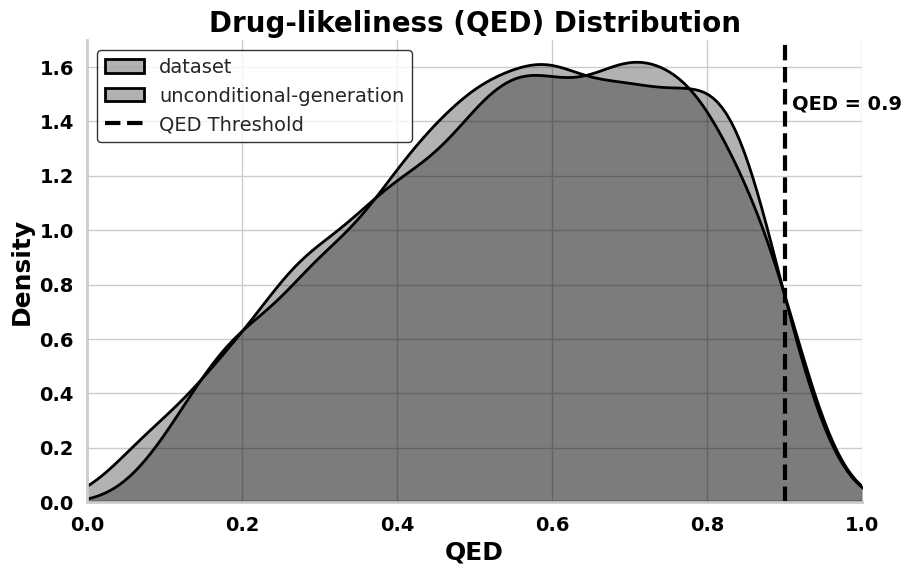

In [29]:
plot(results)

In [73]:
# calculate rmse

import numpy as np
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(logits, properties_valid))

0.113687284

## FUDGE (no future discr.)

In [152]:
import math
import torch 
from torch.nn.functional import log_softmax

# Gaussian Likelihood (Soft Decision)
# Instead of a hard threshold, you can assume that values near 0.9 are more probable and apply a Gaussian function centered at 0.9. This gives a soft probability of the value being close to 0.9.

# Formula (Gaussian Probability)

def calculate_gaussian_log_likelihood(x, mu, sigma):
    return - torch.log(torch.tensor([sigma], device=x.device)) - (1/2) * torch.tensor([2 * math.pi], device=x.device) - (1/2) * ((x - mu) / sigma) ** 2

@torch.no_grad()
def predict_qed(model, input_ids: torch.Tensor, attention_mask: torch.Tensor, target=0.9, sigma = 0.25, **kwargs):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, task='prediction')
        _logits = outputs['logits_physchem']
        _logits = _logits[:, -1]
        log_likelihood = calculate_gaussian_log_likelihood(_logits, target, sigma) 
        return log_likelihood


@torch.no_grad()
def generate_future_token(model, tokenizer, topk=25, temperature=1.0, prompt=None, device='cuda', discriminator_coeff=1.0):

    if prompt is None:
        prompt = torch.tensor(tokenizer.generation_prefix, device=device).long().unsqueeze(0).expand(1, -1)
    
    logits_generation = model(input_ids=prompt, attention_mask=None, next_token_only=True, task='generation')['logits_generation']    
    logits_generation = logits_generation[:, -1, :] / temperature
    log_probs_lm = log_softmax(logits_generation, dim=-1)
    _topk = torch.topk(log_probs_lm, k=topk, dim=-1, largest=True, sorted=True)
    future_token_idx = _topk.indices.transpose(1, 0)
    future_token_log_probs_lm = _topk.values.flatten()
    
    input_ids_future_tokens = torch.cat([prompt.expand(topk, -1), future_token_idx, torch.tensor([tokenizer.sep_token_id], dtype=torch.long, device=device).expand(topk, -1)], dim=-1)   
    future_tokens_probs_prediction = predict_qed(
        model=model,
        input_ids=input_ids_future_tokens,
        attention_mask=torch.full(size=input_ids_future_tokens.size(), fill_value=True, device=device)
        ).flatten()
    
    future_tokens_log_probs = future_token_log_probs_lm + discriminator_coeff * future_tokens_probs_prediction
    future_tokens_probs = torch.softmax(future_tokens_log_probs, dim=0) 
    
    return future_token_idx[torch.multinomial(future_tokens_probs.flatten(), num_samples=1)]

    return torch.cat([prompt, future_token], dim=-1)

In [98]:
prompt = torch.tensor(tokenizer.generation_prefix, device=device).long().unsqueeze(0).expand(1, -1)
prompt.shape

torch.Size([1, 2])

In [113]:
from torch.distributions.normal import Normal

In [114]:
norm = Normal(0.9, 0.25)

norm.log_prob(torch.randn(10))

tensor([ -4.4022,  -1.1904,  -4.6128,  -5.8717,  -2.4896,  -3.8449,  -8.8894,
        -24.2653,  -9.7310, -12.4437])

In [117]:


import math 

torch.log(torch.Tensor([0.2])) - 1/ 2*torch.Tensor([2 * math.pi]) - (0.05 - 0.9) ** 2 / (2 * 0.25 ** 2) 

tensor([-10.5310])

In [102]:
topk = 5
logits_generation = model(input_ids=prompt, attention_mask=None, next_token_only=True, task='generation')['logits_generation']    
logits_generation = logits_generation[:, -1, :] / 1.0
log_probs_lm = log_softmax(logits_generation, dim=-1)
_topk = torch.topk(log_probs_lm, k=topk, dim=-1, largest=True, sorted=True)
future_token_idx = _topk.indices.transpose(1, 0)
future_token_log_probs_lm = _topk.values.flatten()

In [100]:
future_token_log_probs_lm.shape

torch.Size([5])

In [103]:
future_token_idx.shape

torch.Size([5, 1])

In [104]:
prompt.expand(topk, -1).shape

torch.Size([5, 2])

In [106]:
input_ids_future_tokens = torch.cat([prompt.expand(topk, -1), future_token_idx, torch.tensor([tokenizer.sep_token_id], dtype=torch.long, device=device).expand(topk, -1)], dim=-1)   
future_tokens_probs_prediction = predict_qed(
        model=model,
        input_ids=input_ids_future_tokens,
        attention_mask=torch.full(size=input_ids_future_tokens.size(), fill_value=True, device=device)
        ).flatten()
    
    

In [107]:
torch.log(future_tokens_probs_prediction)

tensor([-4.2593, -3.1368, -3.5029, -4.1523, -2.7474], device='cuda:0')

In [108]:
future_tokens_log_probs = future_token_log_probs_lm + 2 * torch.log(future_tokens_probs_prediction)
future_tokens_probs = torch.softmax(future_tokens_log_probs, dim=0) 
    
    

In [109]:
future_tokens_log_probs

tensor([ -8.8127,  -8.0721,  -9.8091, -12.8800, -10.4003], device='cuda:0',
       grad_fn=<AddBackward0>)

In [110]:
future_tokens_probs

tensor([0.2712, 0.5686, 0.1001, 0.0046, 0.0554], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [112]:
future_token_idx[torch.multinomial(future_tokens_probs.flatten(), num_samples=1)].size()

torch.Size([1, 1])

In [142]:
torch.exp(calculate_gaussian_log_likelihood(0.9, 0.9, 0.1)) * 2.5

tensor([1.0803])

In [164]:
tokenizer_config = TokenizerConfig.from_config_file(PATH_TO_TOKENIZER_CONFIG)
tokenizer = AutoTokenizer.from_config(tokenizer_config)

In [157]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
discriminator_coeff = 2.0
num_samples = 64
max_new_tokens = 125
prefix = torch.tensor(tokenizer.generation_prefix, device=device).long().unsqueeze(0).expand(1, -1)
samples = []

for sample in tqdm(range(num_samples)):
    _sample = None
    for new_token in range(max_new_tokens):
        future_token = generate_future_token(model=model, tokenizer=tokenizer, prompt=_sample if sample is not None else prefix, discriminator_coeff=discriminator_coeff, device=device)
        _sample = torch.cat([prefix, future_token], dim=-1) if _sample is None else torch.cat([_sample, future_token], dim=-1)
        if future_token.item() == tokenizer.sep_token_id:
            samples.extend(tokenizer.decode(_sample.detach())) 
            break           
        
properties = oracle(samples)

100%|██████████| 64/64 [00:26<00:00,  2.40it/s]


In [158]:
results['fudge'] = {}
results['fudge']['smiles'] = samples
results['fudge']['qed'] = [str(property) for property in properties.flatten()]
results['fudge']['color'] = 'green'
results['fudge']['validity'] = str(calculate_validity(samples))
results['fudge']['mad'] = str(calculate_mean_absolute_deviation(properties, 0.9))
results['fudge']['std'] = str(calculate_standard_deviation(properties))

In [159]:
properties

array([[0.08112751],
       [0.49057183],
       [       nan],
       [       nan],
       [0.7001711 ],
       [0.19672665],
       [0.78106624],
       [       nan],
       [0.32463315],
       [0.51199526],
       [0.8827831 ],
       [0.446687  ],
       [0.38428822],
       [0.3739979 ],
       [0.4135822 ],
       [0.6209918 ],
       [0.229446  ],
       [0.23964113],
       [0.65355027],
       [0.6729854 ],
       [       nan],
       [0.44440642],
       [       nan],
       [0.68360204],
       [0.3846886 ],
       [0.2978397 ],
       [0.32774767],
       [       nan],
       [0.711378  ],
       [       nan],
       [       nan],
       [0.57731444],
       [       nan],
       [       nan],
       [0.32774767],
       [0.37925684],
       [       nan],
       [0.7705116 ],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [0.6435383 ],
       [0.4135822 ],
       [0.83044994],
       [0.52756006],
       [0.439

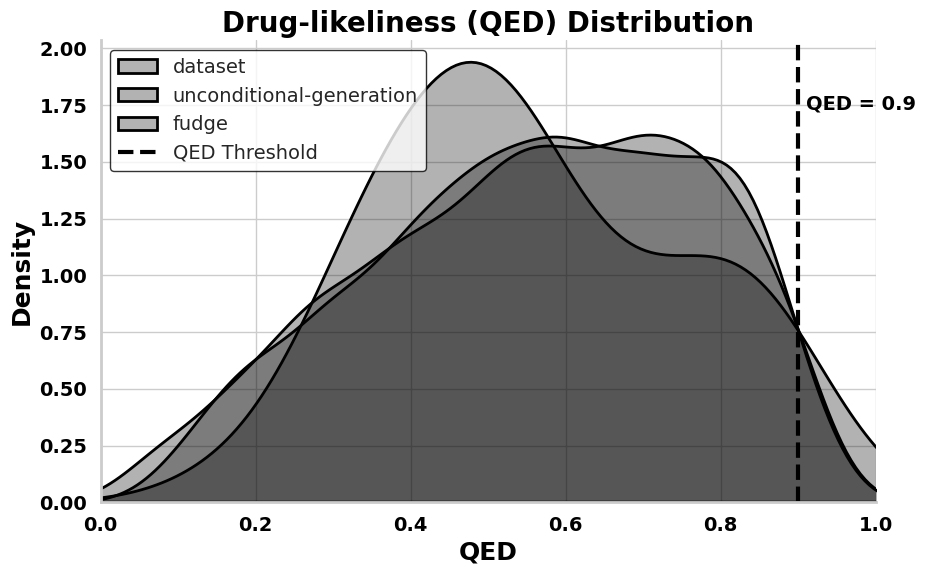

In [156]:
plot(results)

## FUDGE (future discr.)

In [161]:
# Configs

DATA_DIR = '/lustre/groups/aih/hyformer/icml25/data'
OUTPUT_DIR = '/home/adamizdebski/projects/hyformer/results/finetune'

PATH_TO_DATASET_CONFIG   = 'configs/datasets/guacamol_binary_qed/config.json'
PATH_TO_TOKENIZER_CONFIG = 'configs/tokenizers/smiles_separate_task_token_future/config.json'
PATH_TO_MODEL_CONFIG = 'configs/models/hyformer_prediction_best_big/config.json'
PATH_TO_TRAINER_CONFIG = 'configs/trainers/fudge/config.json'

In [162]:
# Test Datsaset

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)

train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')
val_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='val')
test_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='test')


In [163]:
tokenizer_config = TokenizerConfig.from_config_file(PATH_TO_TOKENIZER_CONFIG)
tokenizer = AutoTokenizer.from_config(tokenizer_config)

In [164]:
# Model

model_config = ModelConfig.from_config_file(PATH_TO_MODEL_CONFIG)
model = AutoModel.from_config(model_config, downstream_task=dataset_config.task_type, num_tasks=dataset_config.num_tasks)
# model.load_pretrained('ckpt.pt')
model.to(device)
model.eval()

HyformerForDownstreamPredictionDeep(
  (token_embedding): Embedding(596, 512)
  (layers): ModuleList(
    (0-11): 12 x TransformerLayer(
      (attention_layer): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=False)
        (out): Linear(in_features=512, out_features=512, bias=False)
        (relative_embedding): RotaryPositionalEmbedding()
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=512, out_features=2048, bias=False)
        (w3): Linear(in_features=512, out_features=2048, bias=False)
        (w2): Linear(in_features=2048, out_features=512, bias=False)
      )
      (attention_layer_normalization): RMSNorm()
      (feed_forward_normalization): RMSNorm()
    )
  )
  (layer_norm): RMSNorm()
  (lm_head): Linear(in_features=512, out_features=596, bias=False)
  (mlm_head): Linear(in_features=512, out_features=596, bias=False)
  (physchem_head): RegressionHead(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=

In [165]:
path_to_model_ckpt = '/lustre/groups/aih/hyformer/results_icml25_rebuttal/conditional_sampling/qed_binary/09/fudge/ckpt.pt'

model.load_pretrained(path_to_model_ckpt)

In [166]:
import torch 
from torch.nn.functional import log_softmax


@torch.no_grad()
def generate_future_token(model, tokenizer, topk=25, temperature=1.0, prompt=None, device='cuda', discriminator_coeff=1.0):

    if prompt is None:
        prompt = torch.tensor(tokenizer.generation_prefix, device=device).long().unsqueeze(0).expand(1, -1)
    
    logits_generation = model(input_ids=prompt, attention_mask=None, next_token_only=True, task='generation')['logits_generation']    
    logits_generation = logits_generation[:, -1, :] / temperature
    log_probs_lm = log_softmax(logits_generation, dim=-1)
    _topk = torch.topk(log_probs_lm, k=topk, dim=-1, largest=True, sorted=True)
    future_token_idx = _topk.indices.transpose(1, 0)
    future_token_log_probs_lm = _topk.values
    
    input_ids_future_tokens = torch.cat([prompt.expand(topk, -1), future_token_idx, torch.tensor([tokenizer.sep_token_id], dtype=torch.long, device=device).expand(topk, -1)], dim=-1)   
    future_tokens_probs_prediction = model.predict(
        input_ids=input_ids_future_tokens,
        attention_mask=torch.full(size=input_ids_future_tokens.size(), fill_value=True, device=device)
        ).transpose(1, 0)
    
    future_tokens_log_probs = future_token_log_probs_lm + discriminator_coeff * torch.log(future_tokens_probs_prediction)
    future_tokens_probs = torch.softmax(future_tokens_log_probs, dim=-1) 
    
    return future_token_idx[torch.multinomial(future_tokens_probs, num_samples=1).item()].unsqueeze(0)

    return torch.cat([prompt, future_token], dim=-1)

In [105]:
token_idx = generate_future_token(model, tokenizer, 10, temperature=1.0, prompt=None, discriminator_coeff=1.0)

In [106]:
token_idx.item()

16

In [170]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
discriminator_coeff = 4.0
num_samples = 64
max_new_tokens = 125
prefix = torch.tensor(tokenizer.generation_prefix, device=device).long().unsqueeze(0).expand(1, -1)
samples = []

for sample in tqdm(range(num_samples)):
    _sample = None
    for new_token in range(max_new_tokens):
        future_token = generate_future_token(model=model, tokenizer=tokenizer, prompt=_sample if sample is not None else prefix, discriminator_coeff=discriminator_coeff, device=device)
        _sample = torch.cat([prefix, future_token], dim=-1) if _sample is None else torch.cat([_sample, future_token], dim=-1)
        if future_token.item() == tokenizer.sep_token_id:
            samples.extend(tokenizer.decode(_sample.detach())) 
            break           
        
    

100%|██████████| 64/64 [00:49<00:00,  1.28it/s]


In [171]:
oracle(samples)

array([[0.89525735],
       [0.60735804],
       [0.63918644],
       [0.783382  ],
       [0.48625112],
       [0.2878638 ],
       [0.77394706],
       [0.83156484],
       [0.7006352 ],
       [0.35505384],
       [0.47284374],
       [0.57367676],
       [0.5429869 ],
       [0.7194777 ],
       [0.86222064],
       [0.6956984 ],
       [0.55767953],
       [0.8863048 ],
       [0.55815333],
       [0.7086606 ],
       [0.36167097],
       [0.59214056],
       [0.7475441 ],
       [0.2928259 ],
       [0.86465573],
       [0.44237956],
       [0.8499272 ],
       [0.2879459 ],
       [0.7926267 ],
       [0.44541407],
       [0.45340514],
       [0.46493483],
       [0.8833989 ],
       [0.825956  ],
       [0.4848776 ],
       [0.0424082 ],
       [0.27431154],
       [0.56958586],
       [0.7746457 ],
       [0.52172804],
       [0.6287866 ],
       [0.7418181 ],
       [0.5766943 ],
       [0.7957347 ],
       [0.8873003 ],
       [0.8145477 ],
       [0.64316994],
       [0.573

In [125]:
from rdkit import Chem

def draw_molecule(smiles, output_path, font_size=3.0):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        drawer = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(1400, 1400)  # High-resolution image
        drawer.SetFontSize(font_size)  # Increase atom label font size
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        drawer.show()
        # # Save image
        # with open(output_path, "wb") as f:
        #     f.write(drawer.GetDrawingText())
        # print(f"Saved: {output_path}")

In [126]:
for smiles in samples:
    draw_molecule(smiles, f'{smiles}.png', font_size=3.0)

AttributeError: 'MolDraw2DCairo' object has no attribute 'show'

## Test Metrics 

In [109]:
from hyformer.utils.properties.smiles.physchem import PhysChem
from hyformer.utils.chemistry import is_valid


class QED:

    def __init__(self):
        self.oracle = PhysChem()
        
    def __call__(self, smiles):
        return self.oracle(smiles)[0, -1].item()
    

oracle = QED()

In [127]:
validity = [is_valid(sample) for sample in samples]
qed = [oracle(sample) for sample in samples]

Calculating target data: 100%|██████████| 1/1 [00:00<00:00, 49.45it/s]


In [128]:
validity

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [130]:
qed

[0.32007643580436707,
 0.26108887791633606,
 0.3269159495830536,
 0.44853976368904114,
 0.8397290110588074,
 0.522705614566803,
 0.19290600717067719,
 0.5553812980651855,
 0.35029029846191406,
 0.3390524089336395,
 0.8863059878349304,
 0.9177659153938293,
 0.7276493310928345,
 0.3468707799911499,
 0.3365354537963867,
 0.5029045939445496]

In [38]:
from hyformer.utils.properties.smiles.physchem import PhysChem

class QEDBinaryOracle:

    def __init__(self, threshold):
        self.oracle = PhysChem()
        self.threshold = threshold

    def __call__(self, smiles):
        return self.oracle(smiles)[-1] >= self.threshold

## Implement generation

In [67]:
import torch
from torch.nn.functional import log_softmax


In [87]:
num_future_tokens = 8
temperature = 1.0

In [88]:
prefix = torch.tensor(tokenizer.generation_prefix, device='cuda').long().unsqueeze(0).expand(1, -1)


In [89]:
with torch.no_grad():
    outputs = model(input_ids=prefix, attention_mask=None, next_token_only=True, task='generation')

In [91]:
prefix.expand(num_future_tokens, -1).shape

torch.Size([8, 2])

In [94]:
future_token_idx.transpose(1, 0)

tensor([[ 97],
        [314],
        [ 39],
        [388],
        [121],
        [183],
        [423],
        [375]], device='cuda:0')

In [95]:
torch.cat([prefix.expand(num_future_tokens, -1), future_token_idx.transpose(1, 0)], dim=-1)

tensor([[593, 592,  97],
        [593, 592, 314],
        [593, 592,  39],
        [593, 592, 388],
        [593, 592, 121],
        [593, 592, 183],
        [593, 592, 423],
        [593, 592, 375]], device='cuda:0')

In [ ]:
def complete_to_input(token_ids, task='prediction'):
    return tokenizer.decode(token_ids[0], task=task)

In [ ]:
@torch.no_grad()
    def generate_single_token(self, idx, max_new_tokens, temperature, top_k, eos_token_id, pad_token_id):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """

        eos_flag = torch.zeros(size=(idx.size(0), 1), dtype=torch.bool, device=idx.device)

        for _ in range(max_new_tokens):
            if eos_token_id:
                is_end = torch.logical_or(idx[:, [-1]] == eos_token_id, idx[:, [-1]] == pad_token_id)
                eos_flag = torch.logical_or(eos_flag, is_end)
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.max_seq_len else idx[:, -self.max_seq_len:]
            # forward the model to get the logits for the index in the sequence
            outputs = self(input_ids=idx_cond, attention_mask=None, next_token_only=True, task='generation')
            logits = outputs['logits_generation']

            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature

            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            idx_next = torch.where(eos_flag, torch.ones_like(idx_next) * pad_token_id, idx_next)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
def generate(self, tokenizer, batch_size, temperature, top_k, device):
        """
        Generate complete sequences of indices using the model.
        """
        assert hasattr(tokenizer, 'generation_prefix'), "Tokenizer must have a `generation_prefix` attribute."
        eos_token_id = tokenizer.sep_token_id
        pad_token_id = tokenizer.pad_token_id

        # generate prefix
        prefix = torch.tensor(tokenizer.generation_prefix, device=device).long().unsqueeze(0).expand(batch_size, -1)

        # TODO: implement caching
        idx = self.generate_single_token(prefix, tokenizer.max_molecule_length - 2, temperature, top_k, eos_token_id, pad_token_id)

        # TODO: vectorize
        # check for completion
        for sequence_idx, sequence in enumerate(idx):
            if eos_token_id not in sequence:
                idx[sequence_idx, -1] = eos_token_id
        return idx

In [ ]:

def generate(prompt: torch.Tensor, max_new_tokens: int, temperature: float = 1.0, topk: int = 25):

    

## Additional 

### Get binary classification data from Guacamol (QED >= 0.9, frac=0.002)

In [7]:
import os
import random
import numpy as np


DATA_DIR = '/lustre/groups/aih/hyformer/icml25/data'
DATA_SUFFIX = 'guacamol_binary_qed'
PATH_TO_DATASET_CONFIG  = 'configs/datasets/guacamol/config.json'

SEED = 1337

FRAC_TO_SAMPLE = 0.002
THRESHOLD = 0.9

random.seed(SEED)

In [8]:
data_path = os.path.join(DATA_DIR, DATA_SUFFIX)
if not os.path.exists(data_path):
    os.makedirs(data_path)

In [9]:
# Configs

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)

In [11]:
# Train 

split = 'train'
dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split=split)

n = len(dataset)
indices = random.sample(range(n), int(FRAC_TO_SAMPLE * n)) if split == 'train' else range(n)
sequence = [dataset[idx][0] for idx in indices]
properties = np.array([dataset[idx][1][-1] >= THRESHOLD for idx in indices], dtype=int).reshape(-1, 1)

In [12]:
# Verify 

print(f'Number of samples: {len(sequence)}')
print(f'Fraction of the positive class: {sum(properties) / len(properties)}')

Number of samples: 2546
Fraction of the positive class: [0.1060487]


In [13]:
# Save

np.savez(os.path.join(data_path, f'{split}.npz'), sequence=sequence, properties=properties)

In [14]:
# Val
split = 'val'
dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split=split)

n = len(dataset)
indices = random.sample(range(n), int(FRAC_TO_SAMPLE * n)) if split == 'train' else range(n)
sequence = [dataset[idx][0] for idx in indices]
properties = np.array([dataset[idx][1][-1] >= THRESHOLD for idx in indices], dtype=int).reshape(-1, 1)


In [15]:
# Verify 

print(f'Number of samples: {len(sequence)}')
print(f'Fraction of the positive class: {sum(properties) / len(properties)}')

Number of samples: 79568
Fraction of the positive class: [0.10426302]


In [16]:
# Save

np.savez(os.path.join(data_path, f'{split}.npz'), sequence=sequence, properties=properties)

In [17]:
# Val
split = 'test'
dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split=split)

n = len(dataset)
indices = random.sample(range(n), int(FRAC_TO_SAMPLE * n)) if split == 'train' else range(n)
sequence = [dataset[idx][0] for idx in indices]
properties = np.array([dataset[idx][1][-1] >= THRESHOLD for idx in indices], dtype=int).reshape(-1, 1)


In [18]:
# Verify 

print(f'Number of samples: {len(sequence)}')
print(f'Fraction of the positive class: {sum(properties) / len(properties)}')

Number of samples: 238706
Fraction of the positive class: [0.10383903]


In [19]:
# Save

np.savez(os.path.join(data_path, f'{split}.npz'), sequence=sequence, properties=properties)

In [20]:
_data = np.load(data_path + '/train.npz')

In [21]:
_data['sequence']

array(['COc1ccc(Oc2ccc(C(F)(F)F)cc2C(=O)Nc2cc[nH]c(=O)c2)cc1F',
       'Nc1nc2ccc(C(=O)c3ccccc3)cn2c1C(=O)c1c(F)cccc1F',
       'COc1ccc(C2c3cc4c(cc3OC(NCCO)C2C)OCO4)cc1', ...,
       'O=C(O)CCNc1ccc(-c2nc3ccc(C4(c5ccccc5)CC4)nc3s2)c(F)c1',
       'CCS(=O)(=O)N1CCCc2ccc(NS(=O)(=O)c3ccc(Cl)s3)cc21',
       'CCCc1cc(N2CCC(N3CCCCC3)CC2)ccc1Nc1nccc(-c2c(-c3cccc(C(=O)Nc4c(F)cccc4F)c3)nc3ccccn23)n1'],
      dtype='<U100')

### Get regression data from Guacamol (QED)

In [ ]:
# Imports

import os
import random
import numpy as np

from hyformer.configs.dataset import DatasetConfig
from hyformer.utils.datasets.auto import AutoDataset

from hyformer.utils.runtime import set_seed

from hyformer.utils.properties.smiles.qed import QED

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get binary classification data from Guacamol (QED >= 0.9, frac=0.002)

In [14]:
# Constants

DATA_DIR = '/lustre/groups/aih/hyformer/icml25/data'
DATA_SUFFIX = 'guacamol_qed'
PATH_TO_DATASET_CONFIG  = 'configs/datasets/guacamol/config.json'

SEED = 1337
NUM_SAMPLES = 2000



In [ ]:
# Setup

random.seed(SEED)

data_path = os.path.join(DATA_DIR, DATA_SUFFIX)
if not os.path.exists(data_path):
    os.makedirs(data_path)

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
oracle_qed = QED(verbose=False, dtype='np')


In [49]:
# Train 

split = 'train'
dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split=split)

indices = random.sample(range(len(dataset)), NUM_SAMPLES) if split == 'train' else range(len(dataset))
sequence = [dataset[idx][0] for idx in indices]
properties = oracle_qed(sequence)


mean = np.mean(properties)
std = np.std(properties)

properties = (properties - mean) / std

# Verify
print(f'Number of samples: {len(sequence)}')
print(f'Mean: {np.mean(properties)}')
print(f'Std: {np.std(properties)}')

# Save
np.savez(os.path.join(data_path, f'{split}.npz'), sequence=sequence, properties=properties)




Number of samples: 2000
Mean: 3.976821858486801e-07
Std: 1.0


In [50]:
# Val

split = 'val'
dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split=split)

indices = random.sample(range(len(dataset)), NUM_SAMPLES) if split == 'train' else range(len(dataset))
sequence = [dataset[idx][0] for idx in indices]
properties = oracle_qed(sequence)
properties = (properties - mean) / std

# Verify
print(f'Number of samples: {len(sequence)}')
print(f'Mean: {np.mean(properties)}')
print(f'Std: {np.std(properties)}')

# Save
np.savez(os.path.join(data_path, f'{split}.npz'), sequence=sequence, properties=properties)




Number of samples: 79568
Mean: -0.03861570358276367
Std: 1.0191022157669067


In [51]:
# Test

split = 'test'
dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split=split)

indices = random.sample(range(len(dataset)), NUM_SAMPLES) if split == 'train' else range(len(dataset))
sequence = [dataset[idx][0] for idx in indices]
properties = oracle_qed(sequence)
properties = (properties - mean) / std

# Verify
print(f'Number of samples: {len(sequence)}')
print(f'Mean: {np.mean(properties)}')
print(f'Std: {np.std(properties)}')

# Save
np.savez(os.path.join(data_path, f'{split}.npz'), sequence=sequence, properties=properties)




Number of samples: 238706
Mean: -0.03763950243592262
Std: 1.0188230276107788
